In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install torchinfo

Import Libraries

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

Configuration

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla T4


Seed Value

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

Loading Dataset

In [5]:
data_dir = "/kaggle/input/melanoma/train"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Benign, Count: 6289
Class: Malignant, Count: 5590


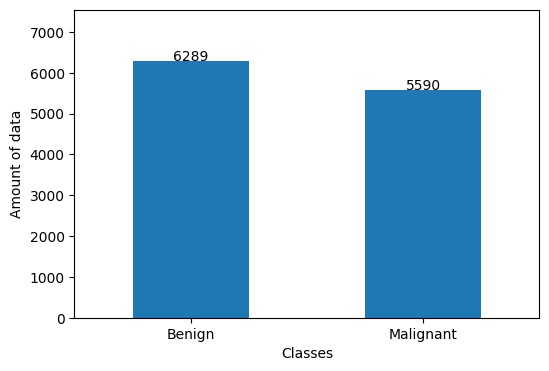

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(6, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

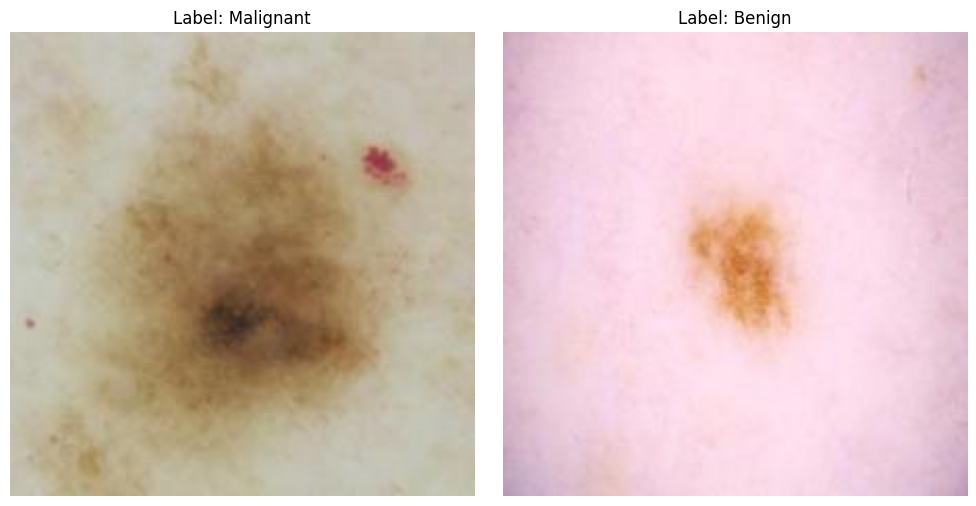

In [7]:
import random
from PIL import Image
import matplotlib.pyplot as plt

classes = df['label'].unique()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for idx, class_label in enumerate(classes):

    class_df = df[df['label'] == class_label]

    random_index = random.randint(0, len(class_df) - 1)
    random_row = class_df.iloc[random_index]

    file_path = random_row['file_path']
    label = random_row['label']

    image = Image.open(file_path)
    axes[idx].imshow(image)
    axes[idx].set_title(f"Label: {label}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


Train-Test-Validation Split (Ratio 70:15:15)

In [8]:
from sklearn.model_selection import train_test_split

# Split into train and validation sets only
train_dataframe, valid_dataframe = train_test_split(
    df,
    test_size=0.30,  # 30% validation, 70% train
    stratify=df['label'],
    random_state=42
)

# Calculate ratios
total = len(df)
train_ratio = len(train_dataframe) / total
valid_ratio = len(valid_dataframe) / total

# Print summary
print(f"Train: {len(train_dataframe)} ({train_ratio:.2%})")
print(f"Validation: {len(valid_dataframe)} ({valid_ratio:.2%})")
print(f"Total: {total}")


Train: 8315 (70.00%)
Validation: 3564 (30.00%)
Total: 11879


In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("-------------------------------------------")
print("Total amount of data in the dataset: ", len(df))


Training Data:  8315
Validation Data:  3564
-------------------------------------------
Total amount of data in the dataset:  11879


In [10]:
from tabulate import tabulate

# Count class occurrences in train and validation datasets
class_counts_train = train_dataframe['label'].value_counts()
class_counts_valid = valid_dataframe['label'].value_counts()

# Format the data for tabulation
train_table_data = [[class_name, count] for class_name, count in class_counts_train.items()]
valid_table_data = [[class_name, count] for class_name, count in class_counts_valid.items()]

# Print the results
print("Train Dataset")
print(tabulate(train_table_data, headers=["Class", "Count"]))
print("\nValidation Dataset")
print(tabulate(valid_table_data, headers=["Class", "Count"]))


Train Dataset
Class        Count
---------  -------
Benign        4402
Malignant     3913

Validation Dataset
Class        Count
---------  -------
Benign        1887
Malignant     1677


Device Variable

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Checkpoint


In [12]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)


Dataset Class, Dataloader and Transform

In [13]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        self.label_map = {'Benign': 0, 'Malignant': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [14]:
from torch.utils.data import DataLoader
from torchvision import transforms

train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    train_dataset = ImageDataset(
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset

dataloader_train_dataset, dataloader_valid_dataset = data_transfrom()


Neural Network (ResNet)

In [17]:
total_class = 2
learning_rate = 0.0001

model = models.resnet50(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, total_class)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
summary(model, input_size=(train_batch, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 2]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [18]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=20, early_stop_patience=5, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0
    consecutive_no_improvement = 0
    num_epochs_loss_greater = 0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)
        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        # Check for early stopping
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")
            consecutive_no_improvement = 0
        else:
            consecutive_no_improvement += 1

        if epoch_val_loss > epoch_train_loss:
            num_epochs_loss_greater += 1
        else:
            num_epochs_loss_greater = 0

        if consecutive_no_improvement >= early_stop_patience or num_epochs_loss_greater >= early_stop_patience:
            print(f"Early stopping criteria met. No improvement in validation accuracy or validation loss for {early_stop_patience} consecutive epochs. Training stopped.")
            break

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/20: 100%|██████████| 260/260 [01:25<00:00,  3.04it/s, acc=0.88, loss=0.278] 

Training Loss: 0.278 Acc: 0.880


Validation Loss: 0.247 Acc: 0.903
Best model saved at epoch 1 with validation accuracy: 0.903


Epoch 2/20: 100%|██████████| 260/260 [01:26<00:00,  2.99it/s, acc=0.917, loss=0.205]

Training Loss: 0.205 Acc: 0.917


Validation Loss: 0.203 Acc: 0.912
Best model saved at epoch 2 with validation accuracy: 0.912


Epoch 3/20: 100%|██████████| 260/260 [01:27<00:00,  2.99it/s, acc=0.943, loss=0.149]

Training Loss: 0.149 Acc: 0.943


Validation Loss: 0.274 Acc: 0.905


Epoch 4/20: 100%|██████████| 260/260 [01:27<00:00,  2.98it/s, acc=0.962, loss=0.106] 

Training Loss: 0.106 Acc: 0.962


Validation Loss: 0.223 Acc: 0.918
Best model saved at epoch 4 with validation accuracy: 0.918


Epoch 5/20: 100%|██████████| 260/260 [01:26<00:00,  2.99it/s, acc=0.972, loss=0.0745]

Training Loss: 0.074 Acc: 0.972


Validation Loss: 0.271 Acc: 0.921
Best model saved at epoch 5 with validation accuracy: 0.921


Epoch 6/20: 100%|██████████| 260/260 [01:27<00:00,  2.98it/s, acc=0.985, loss=0.0463]

Training Loss: 0.046 Acc: 0.985


Validation Loss: 0.281 Acc: 0.920


Epoch 7/20: 100%|██████████| 260/260 [01:27<00:00,  2.98it/s, acc=0.982, loss=0.0469]

Training Loss: 0.047 Acc: 0.982


Validation Loss: 0.295 Acc: 0.917
Early stopping criteria met. No improvement in validation accuracy or validation loss for 5 consecutive epochs. Training stopped.
Training Time: 707.50 seconds ---> 11.79 minutes


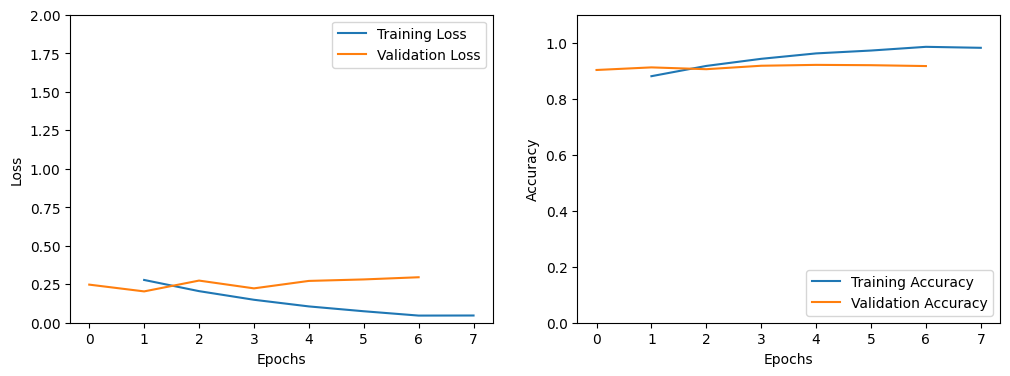

In [19]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

Evaluation

In [20]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [21]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 5) - Validation Loss: 0.271, Validation Accuracy: 0.921


In [24]:
from sklearn.metrics import classification_report
import numpy as np
import torch

def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]
    return class_accuracy

def evaluate_model(model, dataloader, num_classes, dataset_name="Dataset"):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    class_names = [str(i) for i in range(num_classes)]

    print(f"\n=== {dataset_name} Classification Report ===")
    print(classification_report(y_true, y_pred, target_names=class_names))

    class_acc = class_accuracy(model, dataloader, num_classes)
    for i in range(num_classes):
        print(f"{dataset_name} - Class {i} Accuracy: {class_acc[i]:.3f}")

# Run evaluation for both train and validation
evaluate_model(model, train_dataloader, 2, dataset_name="Train")
evaluate_model(model, val_dataloader, 2, dataset_name="Validation")


NameError: name 'train_dataloader' is not defined